In [12]:
#Código baseado no artigo BARRERA
#A ideia deste código é prever um padrão anormal da válvula ICV

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler #pra normalização
from sklearn.metrics import silhouette_score #métrica pros clusters
from sklearn.cluster import KMeans #clustering escolhido
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
import pyswarms as ps #será utilizado para o PSO (particle swarm optimization) pra escolher o número de clusters
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split #Treinamento do modelo
import tensorflow as tf
import seaborn as sns # Pra criar a boxplot, ajudar a definir os clusters





In [13]:
#===========================================
#Leitura do banco de dados
#===========================================
#Por enquanto espera-se o banco já tratado (com menos redundâncias), arquivo csv com as features pré definidas
#Posteriormente talvez dê pra já fazer o heatmap aqui e excluir uma das variáveis que correlaciona fortemente com outra

banco=pd.read_csv("C:/Users/luisa/IA-ICV/IA-ICV/IA_autoencoder/BD731_ComBIEP.csv", sep=';', names=['Qo estimado ICV sup (m³/d)', 'Qi AI MIQ inf (l/h)', 'Pressão LC de abertura CI intermediaria (kgf/cm²)', 'Pressão LC de abertura CI inferior (kgf/cm²)', 'PI Delta P superior (kgf/cm²)', 'PI Delta P inferior (kgf/cm²)', 'RGO (Adim), Qw (m³/d)', 'Qo (m³/d), Qg (m³/d)'])
#banco = banco.iloc[:, 1:] #Essa primeira coluna é só a posição 
print(banco.head())


              Qo estimado ICV sup (m³/d)  Qi AI MIQ inf (l/h)  \
2366.62 1.98                      553.74               553.05   
2366.54 2.11                      553.85               553.15   
2366.47 1.98                      553.85               553.14   
2366.39 2.05                      553.78               553.14   
2366.31 2.08                      553.77               553.06   

              Pressão LC de abertura CI intermediaria (kgf/cm²)  \
2366.62 1.98                                               3.23   
2366.54 2.11                                               3.23   
2366.47 1.98                                               3.23   
2366.39 2.05                                               3.23   
2366.31 2.08                                               3.23   

              Pressão LC de abertura CI inferior (kgf/cm²)  \
2366.62 1.98                                         12.57   
2366.54 2.11                                         12.57   
2366.47 1.98        

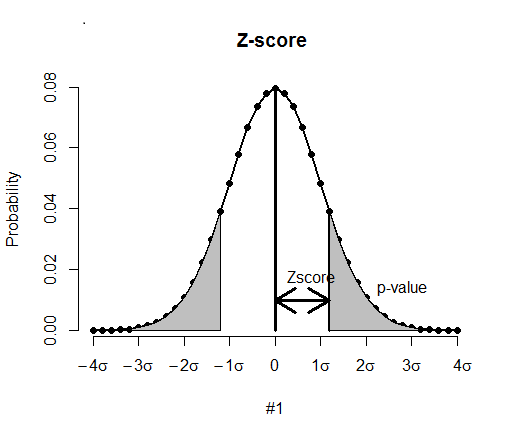

[[ 1.88835001  1.88532214 -0.1369602  ... -0.08213928 -0.06754181
  -0.08095954]
 [ 1.90152806  1.89730861 -0.1369602  ... -0.08213928 -0.06754181
  -0.08095954]
 [ 1.90152806  1.89610996 -0.1369602  ... -0.08213928 -0.06754181
  -0.08095954]
 ...
 [-0.1614345  -0.15357667 -0.99059926 ... -0.57269329 -0.56450269
  -0.42923628]
 [-0.16622651 -0.15597396 -0.89210245 ... -0.57269329 -0.56450269
  -0.42923628]
 [-0.1614345  -0.15237802 -0.79360563 ... -0.57269329 -0.56450269
  -0.42923628]]


In [14]:
#===========================================
#Normalização utilizando o método Z-score
#===========================================
# Z = x - (média)/(desvio), no final a média é 0 e o desvio é 1, então os valores variam 
#entre -1 e 1, isso vai melhorar a eficiência do treinamento.
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(banco)

from IPython.display import Image, display

display(Image(filename='C:/Users/luisa/Downloads/The-relation-of-Z-score-and-p-value-Z-score-is-expressed-in-the-units-of-the-standard.png'))

print(X_normalizado)

In [15]:
def silhouette(n_clusters_array):
    scores = []
    for n in n_clusters_array.astype(int):
        n = int(n)  # converte para int escalar
        if n < 2 or n >= len(X_normalizado):
            scores.append(-1) #Se for menor que 1 ou maior que o número de amostras salva o indicador como -1, que será consequentemente descartado.
            continue
        kmeans = KMeans(n_clusters=n, random_state=42).fit(X_normalizado) #Executa o KMeans com n clusters
        labels = kmeans.labels_ #Obtém os rótulos
        score = silhouette_score(X_normalizado,labels) #Calcula o índice, varia de 1 (bom) até -1 (ruim)
        scores.append(score) #Salva os valores na lista
    return -np.array(scores) #Multiplica por -1 porque o PSO encontra o menor negativo como o melhor.

In [16]:
#===========================================
#PSO para encontrar o melhor número de clusters
#===========================================

bounds = (np.array([1]), np.array([10])) #De 1 até 10 clusters
PSO=ps.single.GlobalBestPSO(n_particles=5, dimensions=1, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7}, bounds=bounds)
best_cost, best_pos = PSO.optimize(silhouette, iters=10)
n_clusters = int(best_pos[0])

print(f'número ótimo de clusters:{n_clusters}')

#double w = 0.729; // inertia weight
#double c1 = 1.49445; // cognitive weight
#double c2 = 1.49445; // social weight

2025-06-11 08:44:19,700 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/10C:\Users\luisa\AppData\Local\Temp\ipykernel_15096\1783121769.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(n)  # converte para int escalar
C:\Users\luisa\AppData\Local\Temp\ipykernel_15096\1783121769.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n = int(n)  # converte para int escalar
C:\Users\luisa\AppData\Local\Temp\ipykernel_15096\1783121769.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in

número ótimo de clusters:7


In [17]:
#===========================================
#Aplicação KMeans
#===========================================

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_normalizado) #Vai gerar um vetor do tamanho de X_normalizado, mas com as posições de cada variáveis, tipo :(1,1,1,2,3,0,1,2,3,3,2)
print(f'Lista posição dos valores em clusters {clusters}')

#===========================================
# Aplicação GMM
#===========================================

#gmm = GaussianMixture(n_components=n_clusters, random_state=42)
#gmm.fit(X_normalizado)
#clusters = gmm.predict(X_normalizado)  # Vetor com os rótulos dos clusters atribuídos
#print(f'Lista posição dos valores em clusters {clusters}')

#===========================================
# Aplicação DBSCAN
#===========================================

#dbscan = DBSCAN(eps=0.5, min_samples=5)  # Ajuste os valores conforme necessário
#clusters = dbscan.fit_predict(X_normalizado)

# eps: distância máxima entre dois pontos para serem considerados vizinhos
# min_samples: número mínimo de pontos para formar uma região densa

#print(f'Lista posição dos valores em clusters: {clusters}')



Lista posição dos valores em clusters [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 2 2 2 2 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

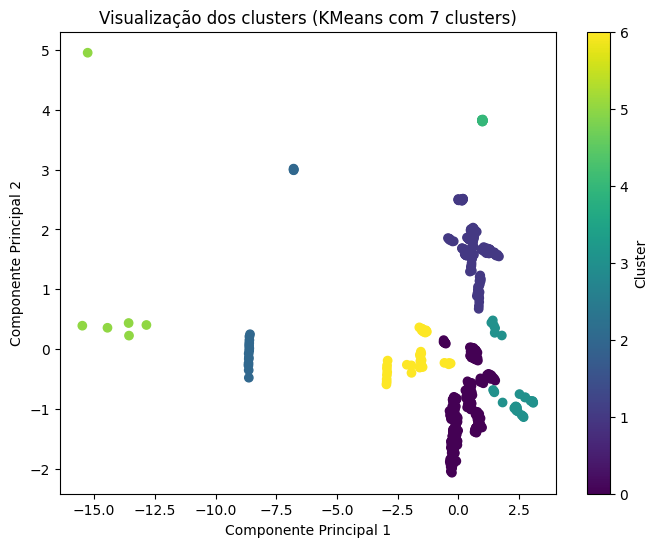

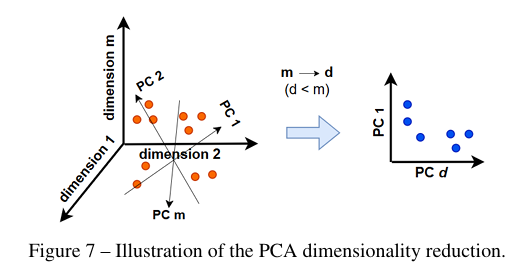

In [18]:
#===========================================
# Visualização dos clusters em 2D com PCA
#===========================================

pca = PCA(n_components=2) #Reduzir os dados originais para 2 dimensões
X_pca = pca.fit_transform(X_normalizado)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters)
plt.title(f'Visualização dos clusters (KMeans com {n_clusters} clusters)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

from IPython.display import Image, display

display(Image(filename="C:/Users/luisa/Pictures/Screenshots/Captura de tela 2025-05-27 233025.png"))



2025-06-11 08:44:20,730 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-11 08:44:20,734 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


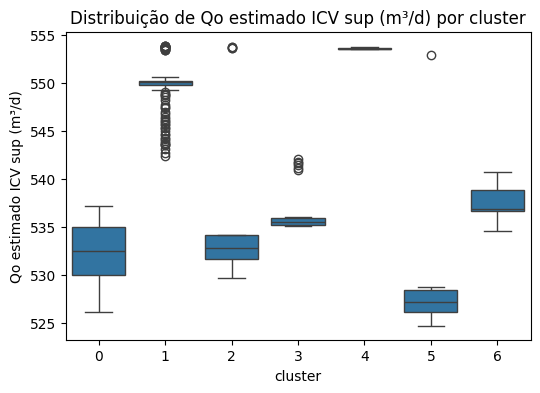

2025-06-11 08:44:20,812 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-11 08:44:20,816 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


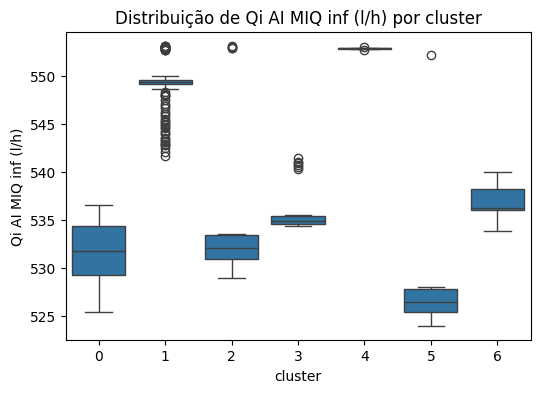

2025-06-11 08:44:20,896 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-11 08:44:20,900 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


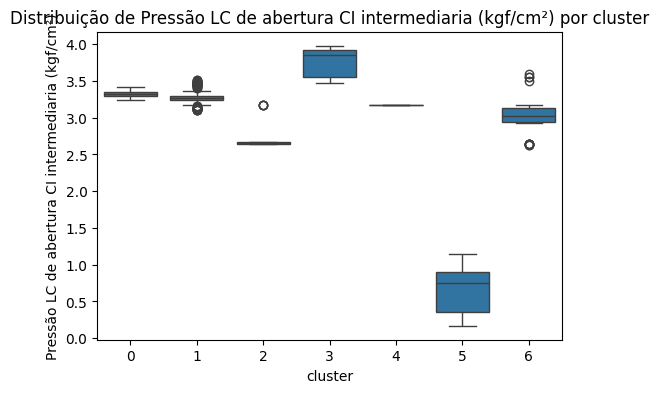

2025-06-11 08:44:20,995 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-11 08:44:20,999 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


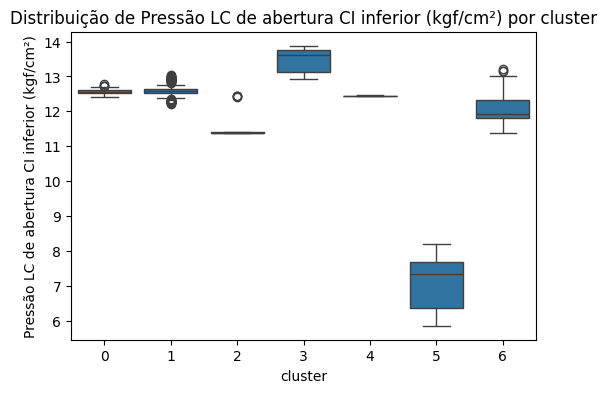

2025-06-11 08:44:21,087 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-11 08:44:21,092 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


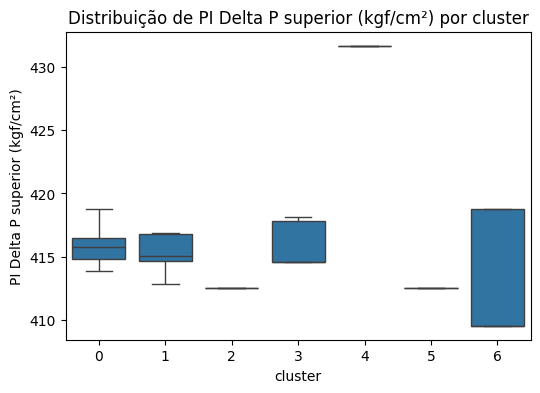

2025-06-11 08:44:21,166 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-11 08:44:21,169 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


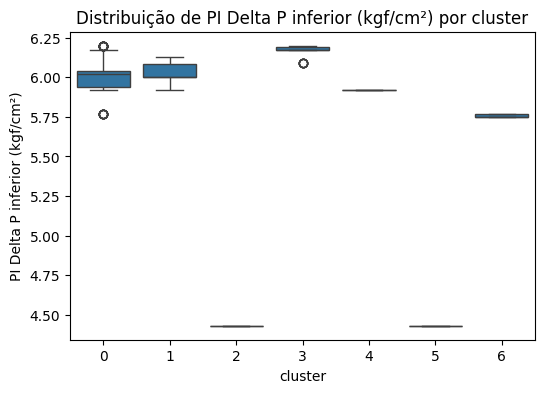

2025-06-11 08:44:21,242 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-11 08:44:21,247 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


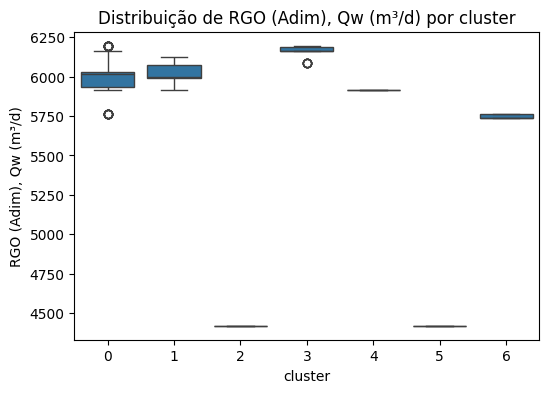

2025-06-11 08:44:21,327 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-11 08:44:21,331 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


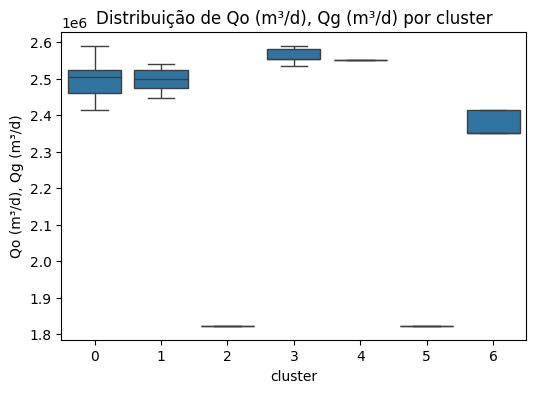

In [19]:
#===========================================
#Boxplot pra auxiliar a nomear os clusters
#===========================================

#Essa função vai fazer o plot de forma estatístico em cima dos valores referentes a cada cluster passando pelo for as variáveis em col.

banco['cluster'] = clusters 

for col in banco.columns[:-1]:  # exclui 'cluster'
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='cluster', y=col, data=banco)
    plt.title(f'Distribuição de {col} por cluster')
    plt.show()

Treinando o autoencoder para o cluster 0
Epoch 161: early stopping
Restoring model weights from the end of the best epoch: 151.
 Erro médio de reconstrução do cluster 0: 0.000312


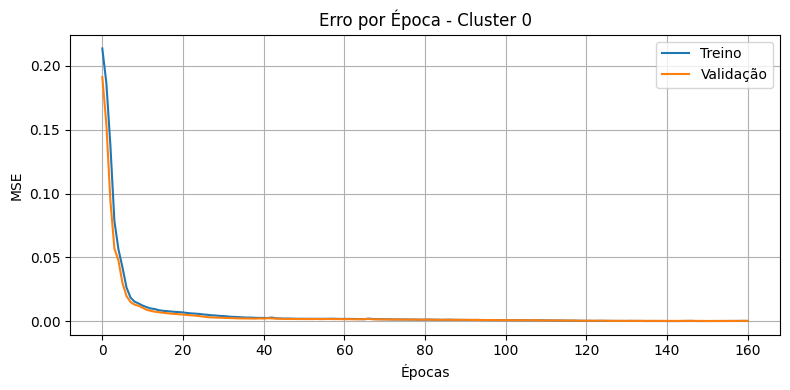

Treinando o autoencoder para o cluster 1
Epoch 248: early stopping
Restoring model weights from the end of the best epoch: 238.
 Erro médio de reconstrução do cluster 1: 0.000209


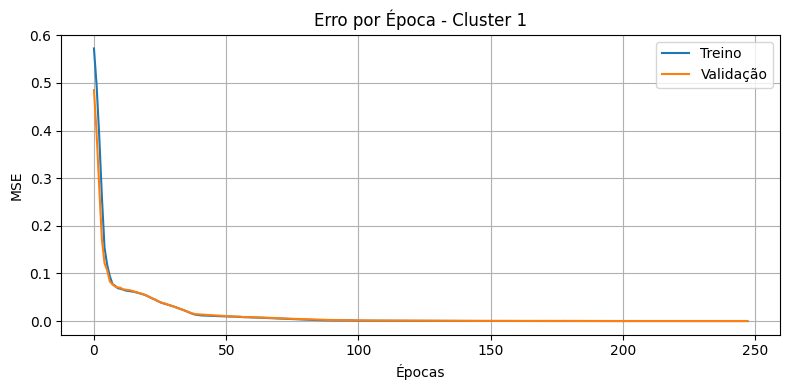

Treinando o autoencoder para o cluster 2
Epoch 78: early stopping
Restoring model weights from the end of the best epoch: 68.
 Erro médio de reconstrução do cluster 2: 0.833596


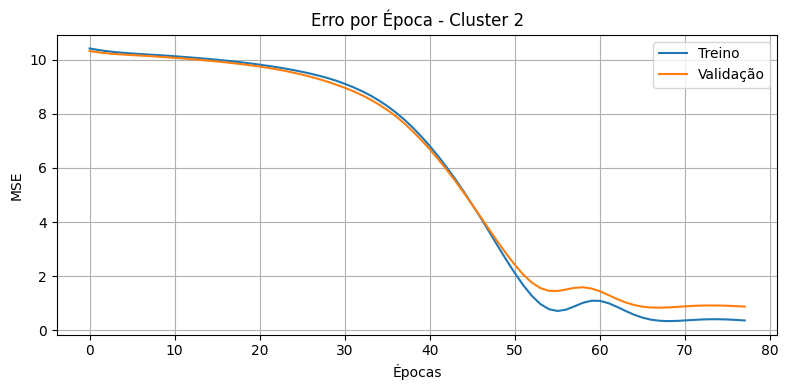

Treinando o autoencoder para o cluster 3
Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 62.
 Erro médio de reconstrução do cluster 3: 0.056397


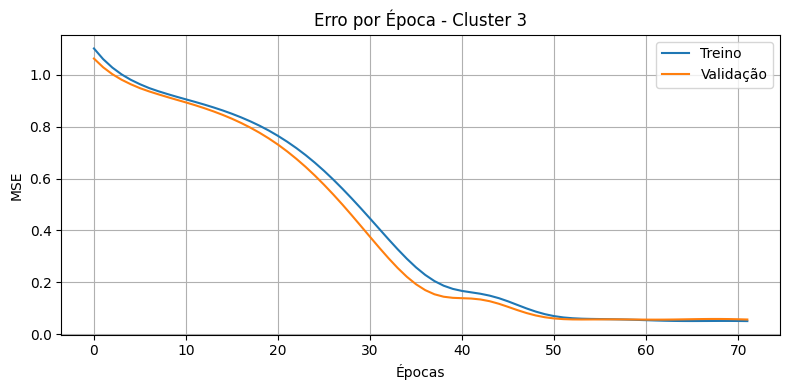

Treinando o autoencoder para o cluster 4
Epoch 56: early stopping
Restoring model weights from the end of the best epoch: 46.
 Erro médio de reconstrução do cluster 4: 0.009756


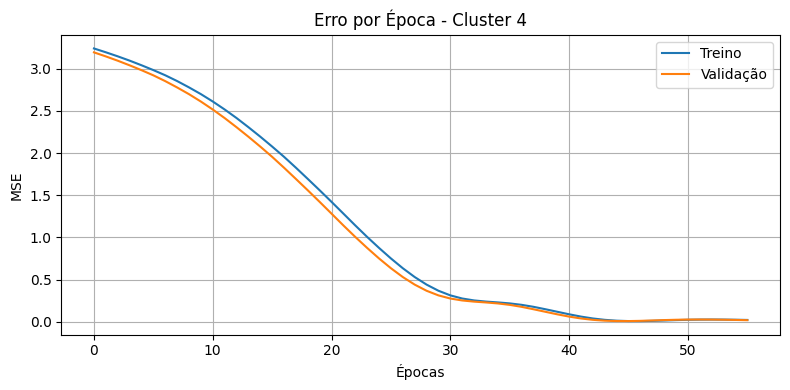

Treinando o autoencoder para o cluster 5
Epoch 54: early stopping
Restoring model weights from the end of the best epoch: 44.
 Erro médio de reconstrução do cluster 5: 2.202656


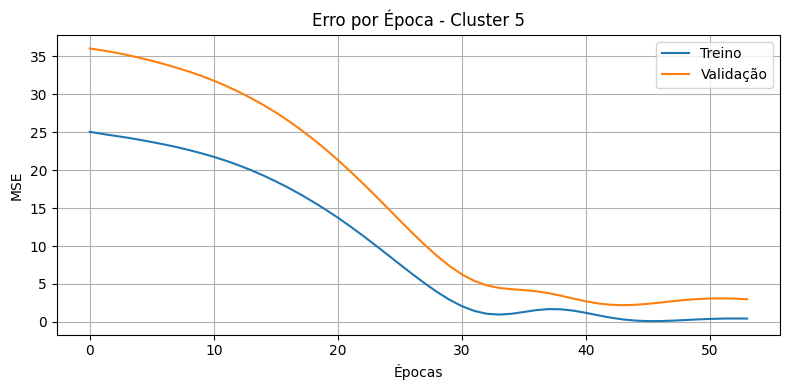

Treinando o autoencoder para o cluster 6
Epoch 201: early stopping
Restoring model weights from the end of the best epoch: 191.
 Erro médio de reconstrução do cluster 6: 0.001003


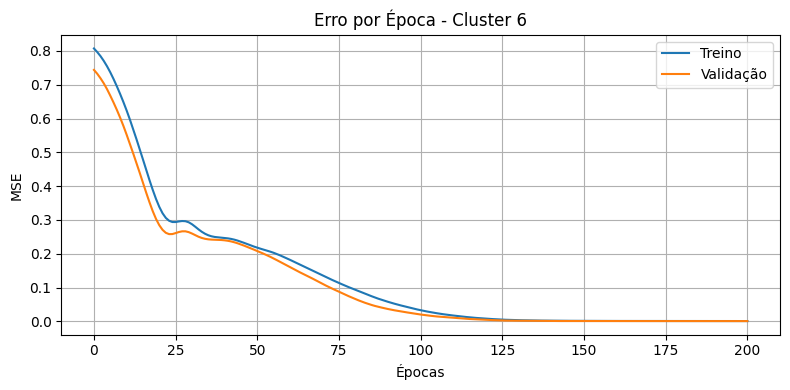

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

autoencoders = {}
erro_reconstrucaos = {}

for cluster_id in range(n_clusters):
    print(f'Treinando o autoencoder para o cluster {cluster_id}')
    X_cluster = X_normalizado[clusters == cluster_id]
    input_dim = X_cluster.shape[1]

    # Estrutura simétrica
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(64, activation='relu')(input_layer)
    encoded = Dense(32, activation='relu')(encoded)
    encoded = Dense(16, activation='relu')(encoded)
    encoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(32, activation='relu')(decoded)
    decoded = Dense(64, activation='relu')(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

    # Divisão treino/teste
    X_train, X_test = train_test_split(X_cluster, test_size=0.2, random_state=42)

    # Callback: EarlyStopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )

    # Treinamento com callback
    history = model.fit(
        X_train, X_train,
        epochs=500,
        batch_size=32,
        validation_data=(X_test, X_test),
        callbacks=[early_stop],
        verbose=0
    )

    # Erro de reconstrução
    reconstruido = model.predict(X_test, verbose=0)
    erros = np.mean((X_test - reconstruido) ** 2, axis=1)
    erro_reconstrucao = np.mean(erros)

    print(f' Erro médio de reconstrução do cluster {cluster_id}: {erro_reconstrucao:.6f}')

    autoencoders[cluster_id] = model
    erro_reconstrucaos[cluster_id] = erro_reconstrucao

    # Plot do histórico de erro
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.title(f'Erro por Época - Cluster {cluster_id}')
    plt.xlabel('Épocas')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
banco_anomalias=pd.read_csv("C:/Users/luisa/IA-ICV/IA-ICV/IA_autoencoder/BD731_ComBIEP_modificado.txt", sep=';', names=['Qo estimado ICV sup (m³/d)', 'Qi AI MIQ inf (l/h)', 'Pressão LC de abertura CI intermediaria (kgf/cm²)', 'Pressão LC de abertura CI inferior (kgf/cm²)', 'PI Delta P superior (kgf/cm²)', 'PI Delta P inferior (kgf/cm²)', 'RGO (Adim), Qw (m³/d)', 'Qo (m³/d), Qg (m³/d)'])
#banco_anomalias = banco_anomalias.iloc[:, 1:] #Essa primeira coluna é só a posição 
print(banco_anomalias)


              Qo estimado ICV sup (m³/d)  Qi AI MIQ inf (l/h)  \
2366.62 1.98                      553.74               553.05   
5000.54 2.11                      553.85               553.15   
2366.47 1.98                      553.85               553.14   
2366.39 2.05                      553.78               553.14   
2366.31 2.08                      553.77               553.06   
...                                  ...                  ...   
2306.41 2.40                      536.78               536.22   
        2.34                      536.68               536.10   
        2.37                      536.63               536.04   
        2.37                      536.59               536.02   
        2.37                      536.63               536.05   

              Pressão LC de abertura CI intermediaria (kgf/cm²)  \
2366.62 1.98                                              40.23   
5000.54 2.11                                               3.23   
2366.47 1.98      

c:\Users\luisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Índices das anomalias detectadas: [  0  16  42  44  71  97 132 201 242 246 251 254 296 303 489 583]
Total de amostras com anomalias: 16


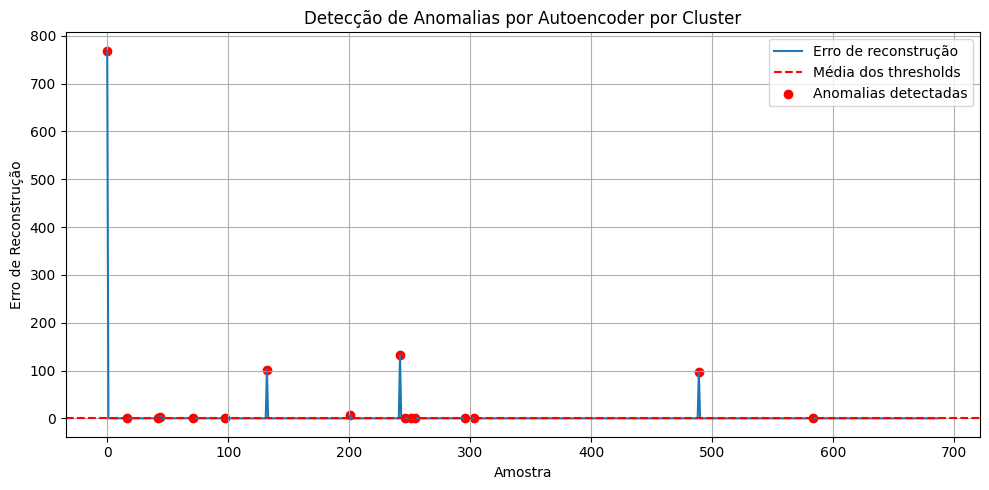

In [22]:
# ===============================================
# DETECÇÃO DE ANOMALIAS USANDO AUTOENCODERS POR CLUSTER
# ===============================================

#Normalização dos valores do banco com anomalias
X_anomalias = banco_anomalias.values
X_anomalias_normalizado = scaler.transform(X_anomalias)

# Kmeans/gmm no banco normalizado
clusters_anomalias = kmeans.predict(X_anomalias_normalizado)

# Para armazenar os resultados
erros_total = np.zeros(len(X_anomalias_normalizado))
anomalias_detectadas = np.zeros(len(X_anomalias_normalizado), dtype=bool)

# Etapa 3: Avaliação por cluster
for cluster_id in range(n_clusters):
    # Selecionar apenas as amostras daquele cluster
    indices_cluster = np.where(clusters_anomalias == cluster_id)[0]
    if len(indices_cluster) == 0:
        continue  # Pula se não houver amostras desse cluster

    X_cluster = X_anomalias_normalizado[indices_cluster]
    model = autoencoders[cluster_id]
    threshold = np.percentile(
        np.mean((X_normalizado[clusters == cluster_id] - model.predict(X_normalizado[clusters == cluster_id], verbose=0)) ** 2, axis=1),
        99
    )

    # Reconstruir e calcular erro
    X_reconstruido = model.predict(X_cluster, verbose=0)
    erros = np.mean((X_cluster - X_reconstruido) ** 2, axis=1)

    # Armazenar resultados
    erros_total[indices_cluster] = erros
    anomalias_detectadas[indices_cluster] = erros > threshold

# Índices das anomalias detectadas
indices_anomalias = np.where(anomalias_detectadas)[0]
print("Índices das anomalias detectadas:", indices_anomalias)

# Etapa 4: Exibir resultados
print("Total de amostras com anomalias:", np.sum(anomalias_detectadas))

# Gráfico geral
plt.figure(figsize=(10, 5))
plt.plot(erros_total, label='Erro de reconstrução')
plt.axhline(y=np.mean(list(erro_reconstrucaos.values())), color='r', linestyle='--', label='Média dos thresholds')
plt.scatter(np.where(anomalias_detectadas), erros_total[anomalias_detectadas], color='red', label='Anomalias detectadas')
plt.legend()
plt.title("Detecção de Anomalias por Autoencoder por Cluster")
plt.xlabel("Amostra")
plt.ylabel("Erro de Reconstrução")
plt.grid(True)
plt.tight_layout()
plt.show()

#Alterações feitas no banco original - 
#'Qo estimado ICV sup (m³/d)', 'Qi AI MIQ inf (l/h)', 'Pressão LC de abertura CI intermediaria (kgf/cm²)', 'Pressão LC de abertura CI inferior (kgf/cm²)', 'PI Delta P superior (kgf/cm²)', 'PI Delta P inferior (kgf/cm²)', 'RGO (Adim), Qw (m³/d)', 'Qo (m³/d), Qg (m³/d)'

#Linha zero - delta P inferior 
#Linha 132 - PI delta P sup, Pressão LC de abertura
#Linha 201 - Qo estimado ICV sup (m³/d), Qi AI MIQ inf (l/h), Qo, Qg
#Linha 242 - PI delta P sup e inf, qw
#Linha 489 - Pressão LC de abertura